<a href="https://colab.research.google.com/github/jihye134seo/2022-DataCreatorCamp/blob/practice/practice/CatDog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /content/cats_and_dogs_filtered.zip

--2022-10-28 08:04:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   278MB/s    in 0.2s    

2022-10-28 08:04:25 (278 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip cats_and_dogs_filtered.zip
!rm -rf cats_and_dogs_filtered.zip

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time


base_dir = '/content/cats_and_dogs_filtered';
train_dir = os.path.join(base_dir, 'train');
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')



In [ ]:
train_cats = os.listdir(train_cats_dir)
train_cats.sort()
train_dogs = os.listdir(train_dogs_dir)
train_dogs.sort()


In [ ]:
data_transforms = {
    'train' : transforms.Compose({
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    }),
    'validation' : transforms.Compose({
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
       
    })

}

In [ ]:
data_transforms

{'train': Compose(
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ), 'validation': Compose(
     CenterCrop(size=(224, 224))
     ToTensor()
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x),
                                           data_transforms[x])
                  for x in ['train', 'validation',]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'validation',]}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation',]}

class_names = image_datasets['train'].classes


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array(
      [0.485, 0.456, 0.406]
  )
  std = np.array(
      [0.229, 0.224, 0.225]
  )

  inp = std*inp+mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  


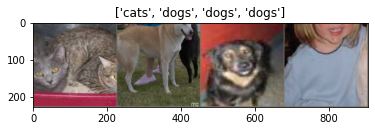

In [ ]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, optimizer, criterion, schedular, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epochs in range(num_epochs):
    print('EPOCH {}/{}'.format(epochs, num_epochs-1))
    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, (inputs, labels) in enumerate(dataloaders[phase]):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        schedular.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

    
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc
      ))

      if phase == 'validation' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since

  temp_a = time_elapsed//60
  temp_b = time_elapsed%60

  print('Training complete in {:.0f}m {:.0f}s'.format(temp_a, temp_b))
  print('Best val Acc: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model



In [ ]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['validation']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
      model.train(mode=was_training)



In [ ]:
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
  param.requires_grad = True


model.classifier._modules['6'] = nn.Linear(4096, 2)
parameters = model.classifier._modules['6'].parameters()
model = model.to(device)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

EPOCH 0/4
train Loss: 0.1636 Acc: 0.9370
validation Loss: 0.0612 Acc: 0.9760

EPOCH 1/4
train Loss: 0.1770 Acc: 0.9370
validation Loss: 0.0600 Acc: 0.9760

EPOCH 2/4
train Loss: 0.1818 Acc: 0.9410
validation Loss: 0.0626 Acc: 0.9800

EPOCH 3/4
train Loss: 0.1996 Acc: 0.9415
validation Loss: 0.0524 Acc: 0.9800

EPOCH 4/4
train Loss: 0.1785 Acc: 0.9465
validation Loss: 0.0706 Acc: 0.9770

Training complete in 4m 26s
Best val Acc: 0.9800


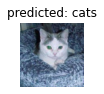

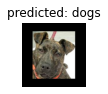

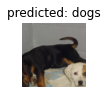

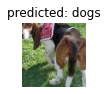

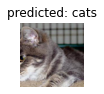

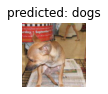

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(parameters, lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.1)

model = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=5)

visualize_model(model)

plt.ioff()
plt.show()